In [136]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os 
import random

In [137]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHEED'] = str(seed)
  np.random.seed(seed)
seed_everything(42)

In [138]:
dataPath = 'D:\\Data\\LGAI_AutoDriveSensors\\'

#import train and test CSV files
train = pd.read_csv(dataPath+'train.csv')
test = pd.read_csv(dataPath+"test.csv")

In [139]:
train_x = train.filter(regex='X')
train_y = train.filter(regex = "Y")
test_x = test.filter(regex='X')


---
Functions

In [140]:

# DATA Preprocessing
def drop_columns(x, cols) : 
    return x.drop(cols, axis='columns')

def group_mean(x, cols) :
    x_cols = x.loc[:,cols]
    cols_means = x_cols.mean(axis='columns')
    return cols_means

def add_col(x, col_name, value) :
    x[col_name] = value

def make_mean_col(x, cols, col_name) :
    cols_mean = group_mean(x, cols)
    x = drop_columns(x, cols)
    add_col(x, col_name, cols_mean)
    return x

def IQR_except_outlier(col) : 
    Q3, Q1 = np.percentile(col, [75, 25])
    IQR = Q3 - Q1
    lower, upper = Q1-1.5*IQR, Q3+1.5*IQR
    data_low_idx = col[lower > col].index
    data_upper_idx = col[upper < col].index
    execpt_outlier = col[(lower < col) & (upper > col)]

    # outlier를 뺀 값들의 min과 max 값으로 대체함
    min = execpt_outlier.min()
    max = execpt_outlier.max()

    col[data_low_idx] = min
    col[data_upper_idx] = max

    return col

def standardization (data) :
    # z = (x - mean())/std()
    return (data - np.mean(data, axis=0)) / np.std(data, axis=0)

def preprocessing_x (x_data) : 
    # 1차, 2차, 3차 4차 검사 통과 여부 칼럼 제거함 (모두 동일한 값 1, 모두 통과함)
    pass_columns = ['X_04','X_23','X_47','X_48']
    x_data = drop_columns(x_data, pass_columns)

    # 안테나 패드 위치 평균 칼럼 만들기 'X_57'
    x_data = make_mean_col(x_data, ['X_14','X_15','X_16','X_17','X_18'], 'X_57')

    # 커넥터 핀 치수 평균 칼럼 만들기 'X_59'
    x_data = make_mean_col(x_data, ['X_24','X_25','X_26','X_27','X_28','X_29'], 'X_59')
    # 스크류 삽입 깊이 n 평균 칼럼 만들기 'X_60'
    # IQR 사용하여 이상치 처리, 이상치를 제거했을 때의 min과 max 값으로 대체
    x_data.loc[:,'X_30'] = IQR_except_outlier(x_data.loc[:,'X_30'].copy())
    x_data.loc[:,'X_31'] = IQR_except_outlier(x_data.loc[:,'X_31'].copy())
    x_data.loc[:,'X_32'] = IQR_except_outlier(x_data.loc[:,'X_32'].copy())
    x_data.loc[:,'X_33'] = IQR_except_outlier(x_data.loc[:,'X_33'].copy())

    # 하우징 PCB 안착부 평균 칼럼 만들기 'X_62'
    x_data = make_mean_col(x_data, ['X_38','X_39','X_40'], 'X_62')

    # PCB 체결 시 단계별 누름량 이상치 제거
    x_data.loc[:,'X_06'] = IQR_except_outlier(x_data.loc[:,'X_06'].copy())
    
    # 표준화
    # x_data = standardization(x_data)
    
    return x_data



---

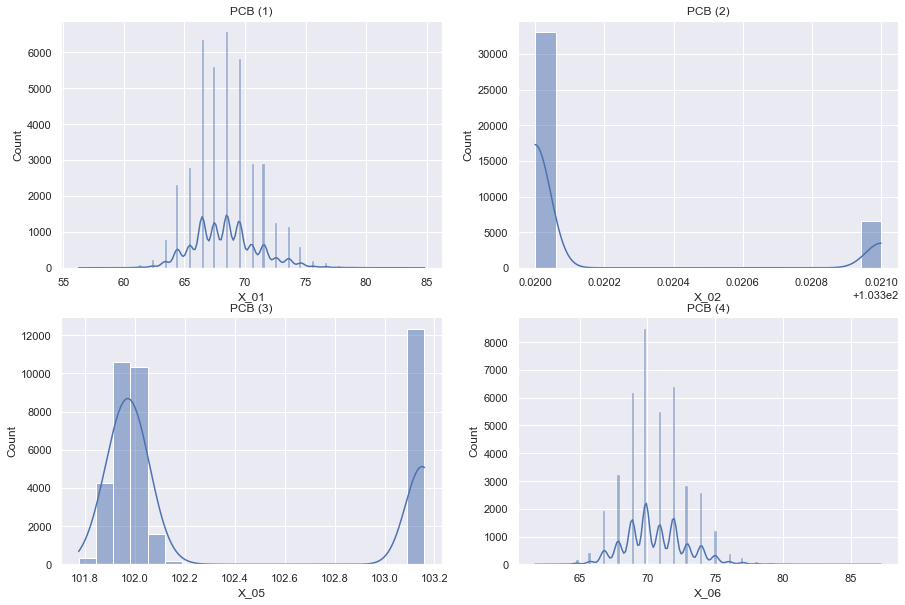

In [141]:
pcb = train_x[['X_01','X_02','X_05','X_06']]

# PCB 체결 시 단계별 누름량
fig, axes = plt.subplots(2,2, figsize = (15,10))

sns.histplot(data = pcb, x = "X_01", kde = True, ax = axes[0,0]).set(title = "PCB (1)")
sns.histplot(data = pcb, x = "X_02", kde = True, ax = axes[0,1]).set(title = "PCB (2)")
sns.histplot(data = pcb, x = "X_05", kde = True, ax = axes[1,0]).set(title = "PCB (3)")
sns.histplot(data = pcb, x = "X_06", kde = True, ax = axes[1,1]).set(title = "PCB (4)")

plt.show()

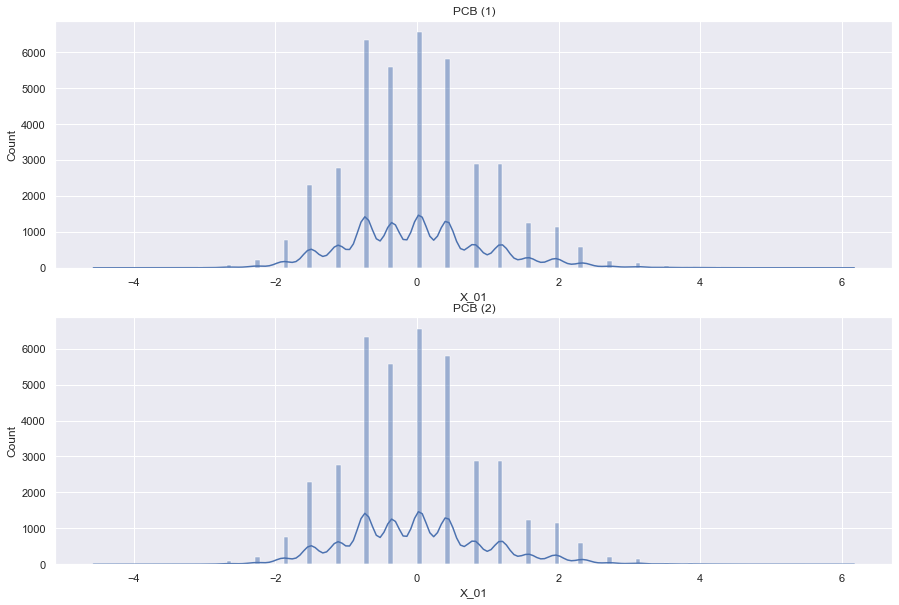

In [142]:
pcb = train_x[['X_01', 'X_06']]
pcb = standardization(pcb)

# PCB 체결 시 단계별 누름량
fig, axes = plt.subplots(2,1, figsize = (15,10))

sns.histplot(data = pcb, x = "X_01", kde = True, ax = axes[0]).set(title = "PCB (1)")
sns.histplot(data = pcb, x = "X_01", kde = True, ax = axes[1]).set(title = "PCB (2)")


plt.show()

In [143]:
train_x[['X_01', 'X_06']] = pcb.copy()

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [147]:
x = train_x[['X_05']]

label0 = train_x[['X_05']] >= 102.5
label1 = train_x[['X_05']] < 102.5
train_x[label0] = 0
train_x[label1] = 1

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [166]:
label0 = train_x[['X_02']] >= 0.0205+1.033e2
label1 = train_x[['X_02']] < 0.0205+1.033e2
train_x[label0] = 0
train_x[label1] = 1

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\pandas\core\frame.py:3718: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [167]:
train_x[['X_02']]

,X_02
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
39602,1.0
39603,0.0
39604,1.0
39605,1.0


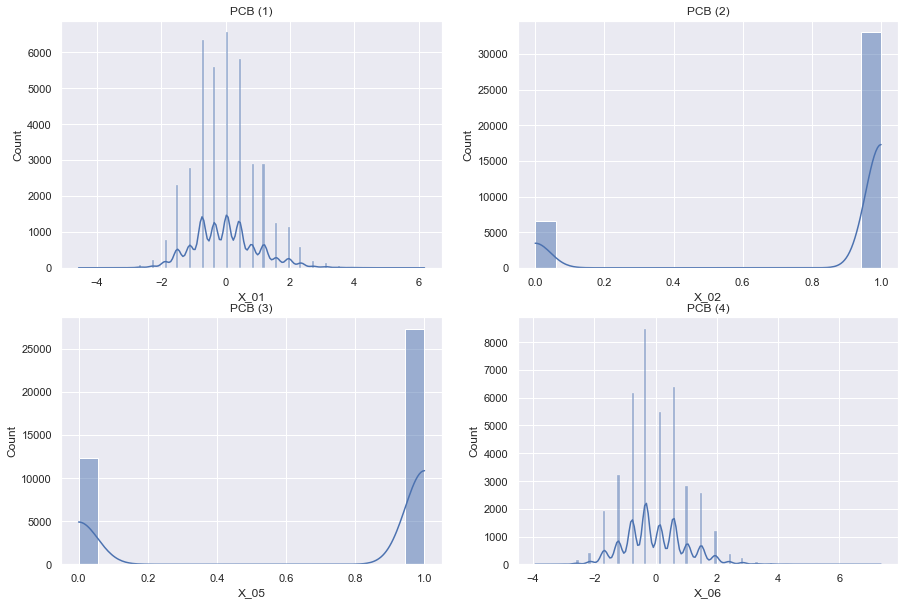

In [168]:
pcb = train_x[['X_01','X_02','X_05','X_06']]

# PCB 체결 시 단계별 누름량
fig, axes = plt.subplots(2,2, figsize = (15,10))

sns.histplot(data = pcb, x = "X_01", kde = True, ax = axes[0,0]).set(title = "PCB (1)")
sns.histplot(data = pcb, x = "X_02", kde = True, ax = axes[0,1]).set(title = "PCB (2)")
sns.histplot(data = pcb, x = "X_05", kde = True, ax = axes[1,0]).set(title = "PCB (3)")
sns.histplot(data = pcb, x = "X_06", kde = True, ax = axes[1,1]).set(title = "PCB (4)")

plt.show()

---

[Text(0.5, 1.0, 'Heating material area and weight')]

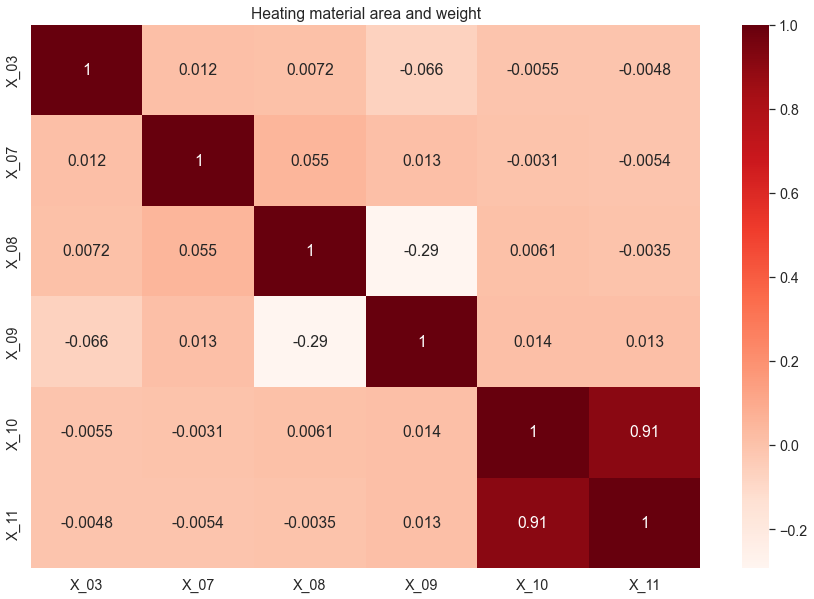

In [ ]:
# 방열 재료 1 면적 및 무게
heat = train_x[['X_03', 'X_07', 'X_08', 'X_09', 'X_10', 'X_11']]

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

ax = plt.axes()
sns.heatmap(heat.corr(),annot = True, cmap = 'Reds', ax = ax).set(title = "Heating material area and weight")

In [ ]:
train_x = make_mean_col(train_x, ['X_10','X_11'], 'X_65')

[Text(0.5, 1.0, 'Heating material area and weight')]

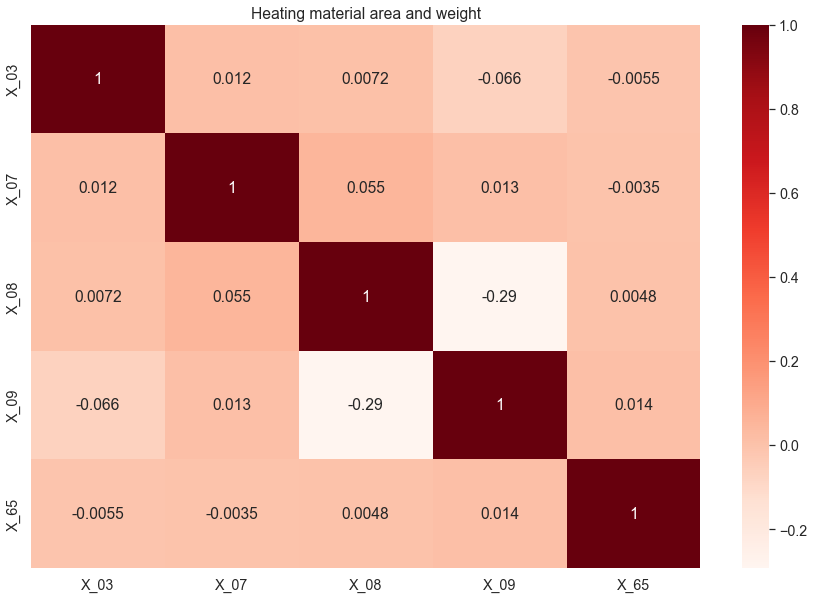

In [ ]:
# 방열 재료 1 면적 및 무게
heat = train_x[['X_03', 'X_07', 'X_08', 'X_09', 'X_65']]

plt.figure(figsize = (15,10))

sns.set(font_scale = 1.3)

ax = plt.axes()
sns.heatmap(heat.corr(),annot = True, cmap = 'Reds', ax = ax).set(title = "Heating material area and weight")

---

Text(0.5, 0.98, 'Antenna Pad Location')

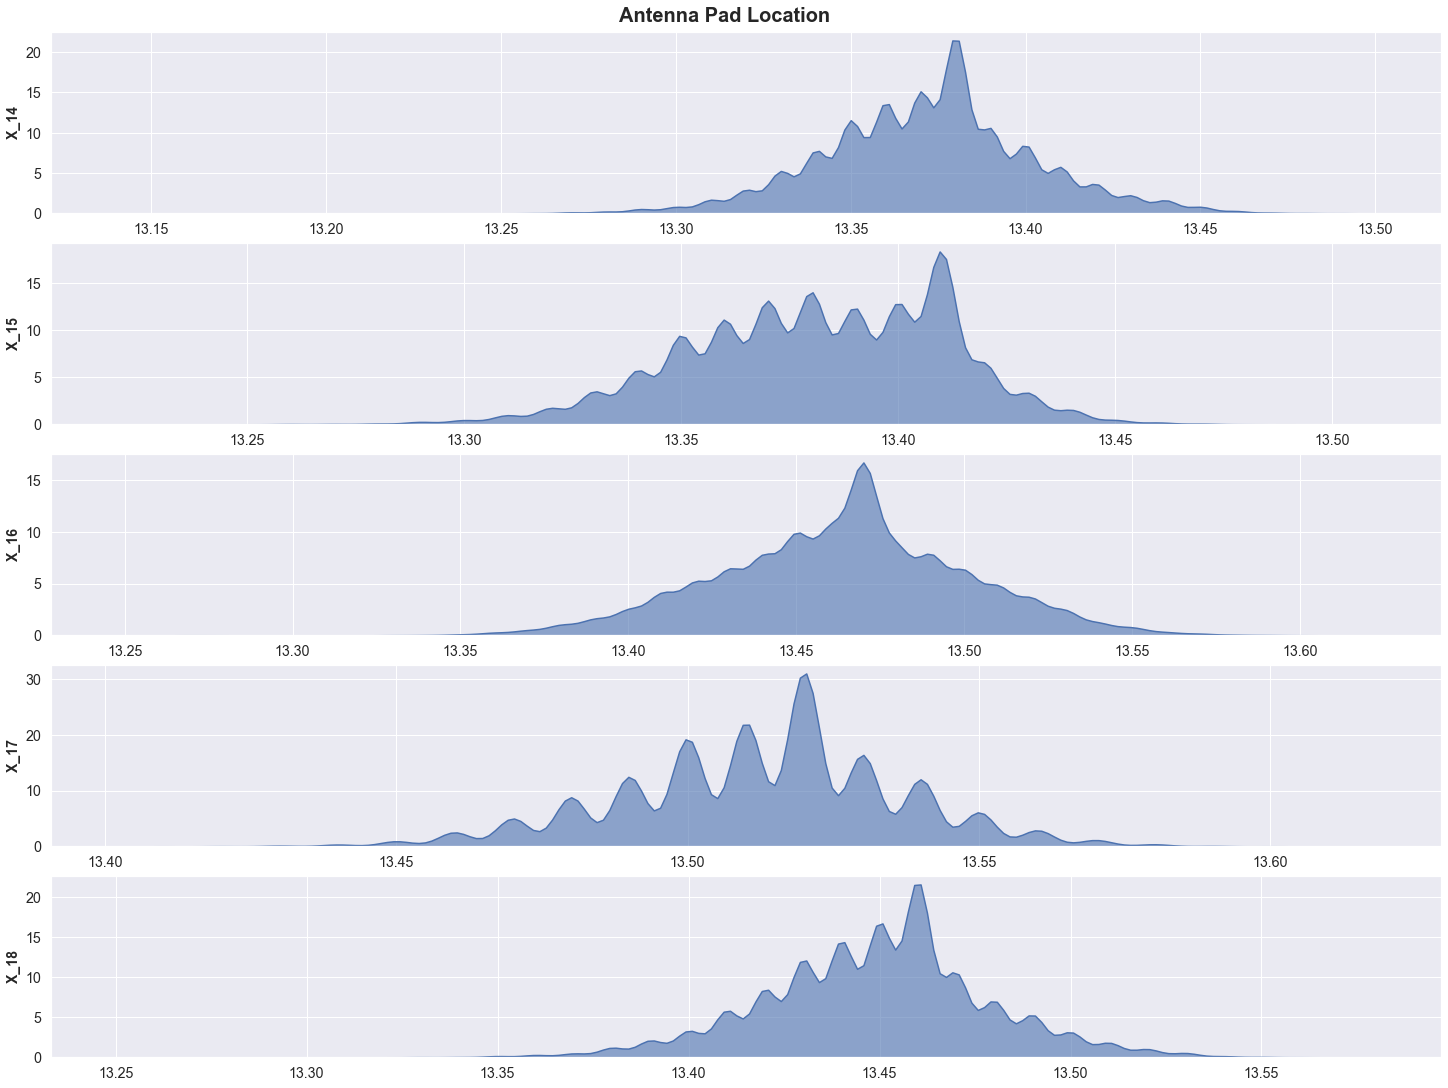

In [ ]:
# 안테나 패드 위치

antenna = train_x[['X_14','X_15','X_16','X_17','X_18']]

type_col = ['X_14','X_15','X_16','X_17','X_18']

fig, ax = plt.subplots(5, 1, figsize=(20,15), constrained_layout = True)

for i, col in enumerate(type_col):
  sns.kdeplot(x = col, data = antenna, fill = True, alpha = 0.6, linewidth = 1.5, ax = ax[i])
  ax[i].set_xlabel(None)
  ax[i].set_ylabel(col, size = 14, weight = 'bold')

fig.suptitle('Antenna Pad Location', size = 20, weight = 'bold')

Text(0.5, 0.98, 'Antenna Pad Location')

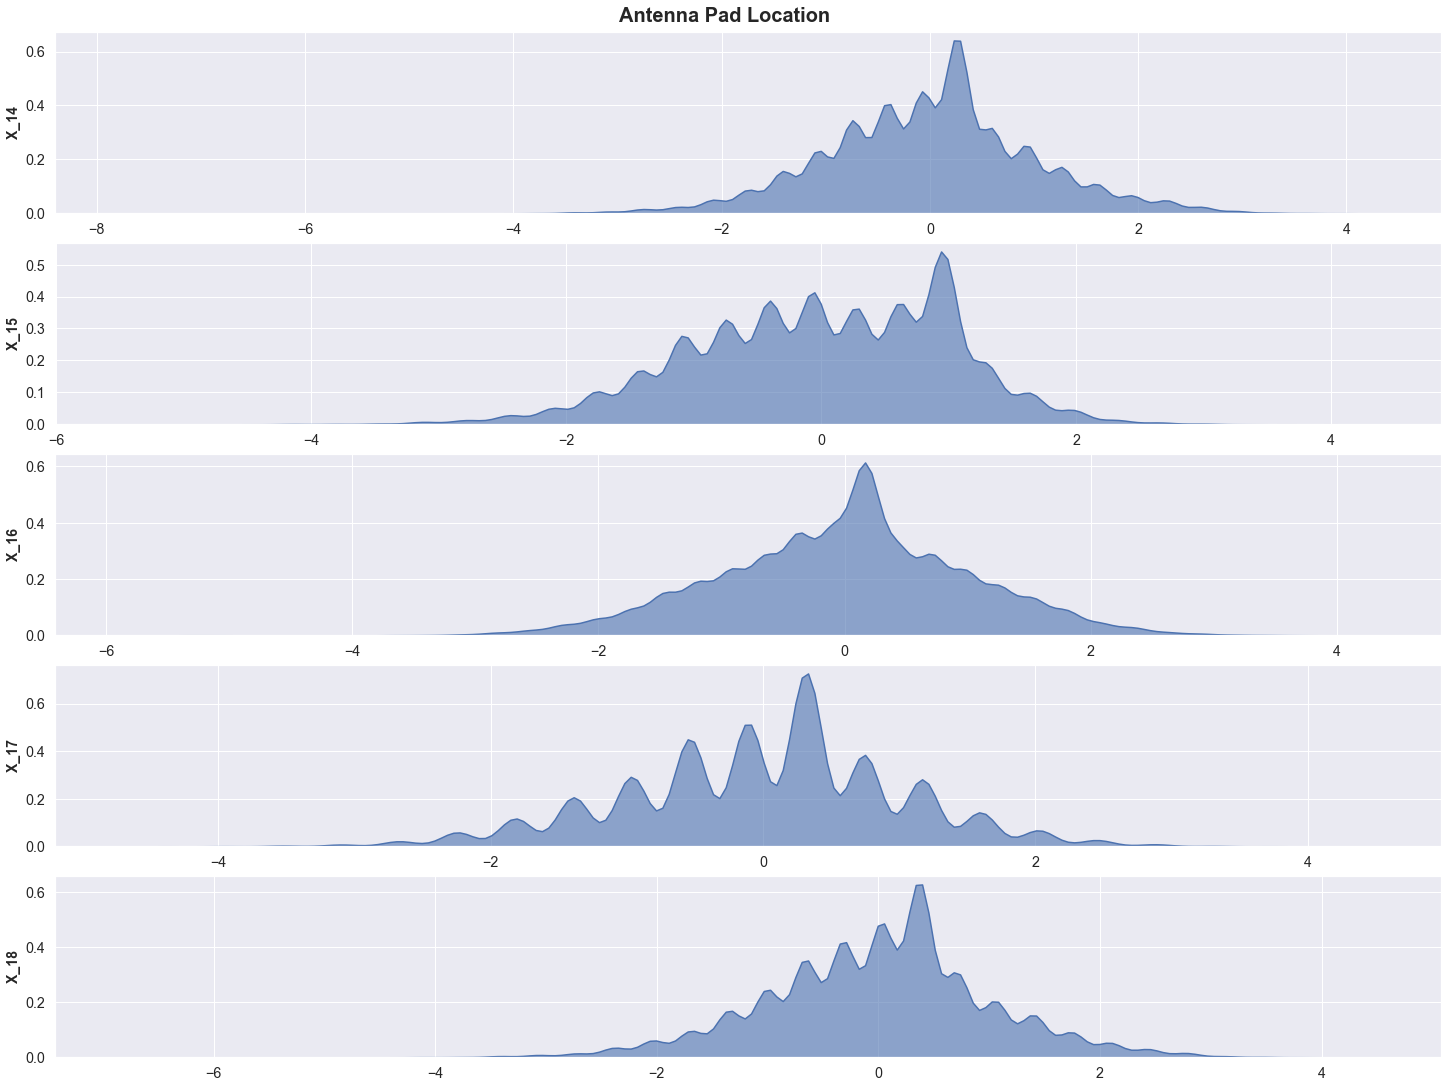

In [ ]:
antenna = standardization(antenna)

type_col = ['X_14','X_15','X_16','X_17','X_18']

fig, ax = plt.subplots(5, 1, figsize=(20,15), constrained_layout = True)

for i, col in enumerate(type_col):
  sns.kdeplot(x = col, data = antenna, fill = True, alpha = 0.6, linewidth = 1.5, ax = ax[i])
  ax[i].set_xlabel(None)
  ax[i].set_ylabel(col, size = 14, weight = 'bold')

fig.suptitle('Antenna Pad Location', size = 20, weight = 'bold')


---

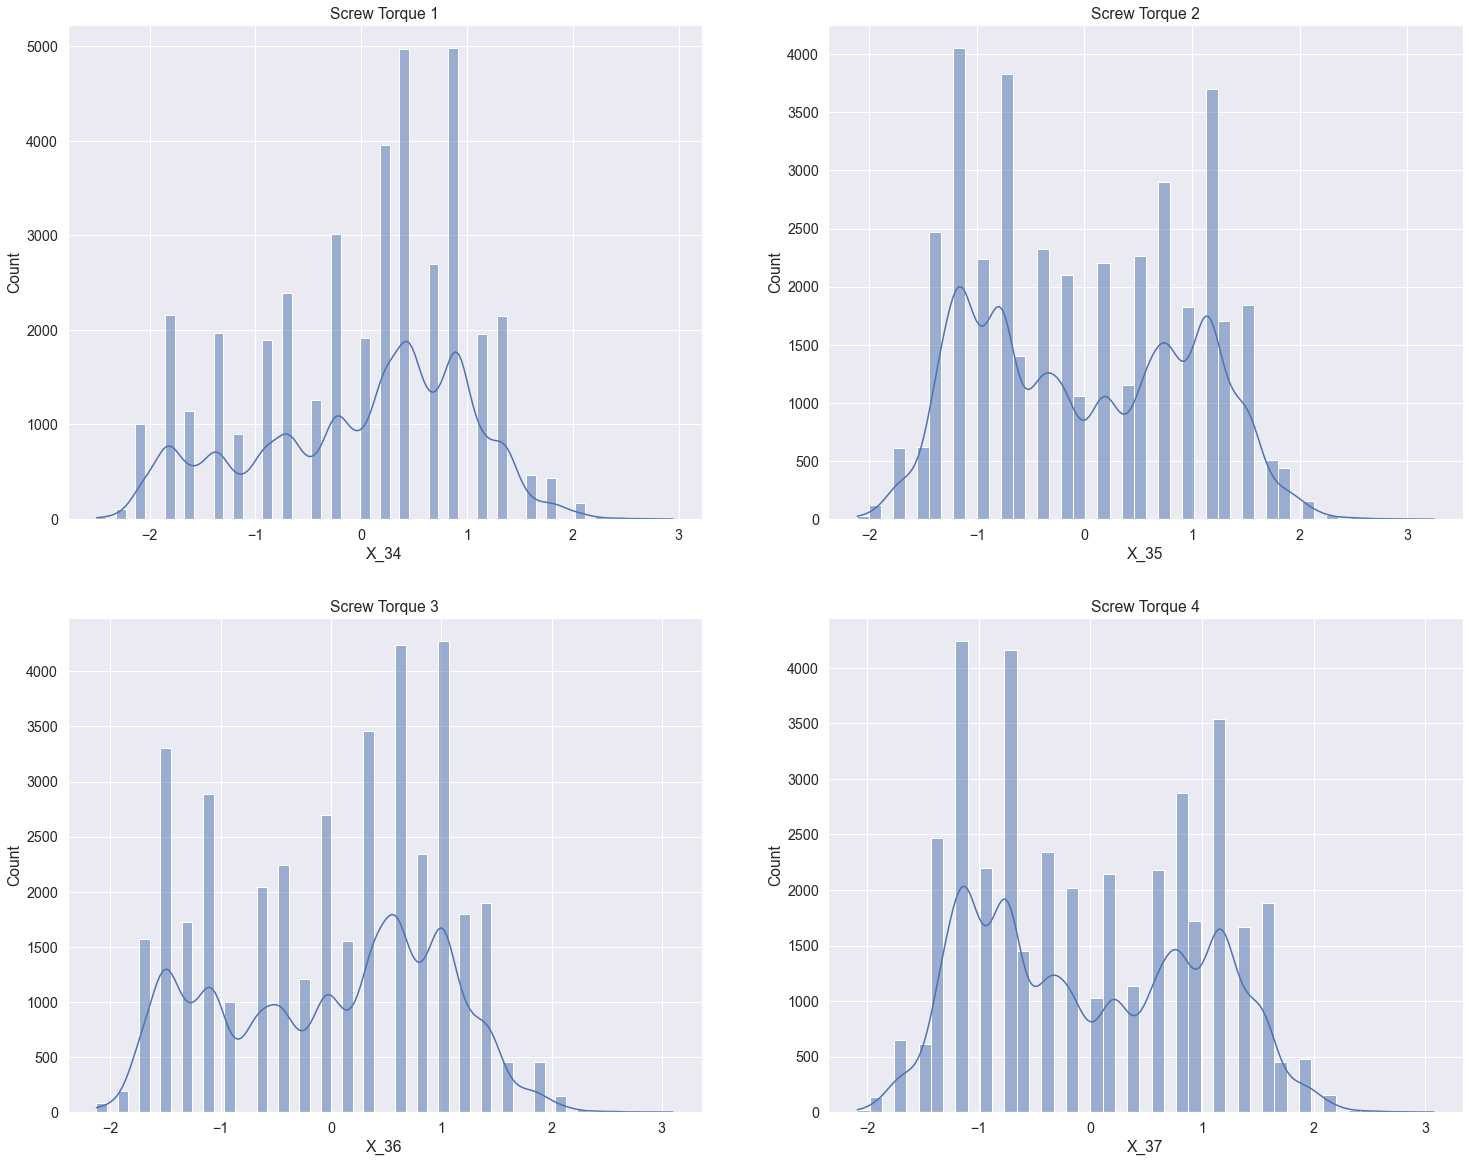

In [ ]:
screw = train_x[['X_34','X_35','X_36','X_37']]

screw = standardization(screw)

# 스크류 체결 시 분당 회전수

fig, axes = plt.subplots(2,2, figsize = (25,20))

sns.histplot(data = screw, x = "X_34", kde = True, ax = axes[0,0]).set(title = "Screw Torque 1")
sns.histplot(data = screw, x = "X_35", kde = True, ax = axes[0,1]).set(title = "Screw Torque 2")
sns.histplot(data = screw, x = "X_36", kde = True, ax = axes[1,0]).set(title = "Screw Torque 3")
sns.histplot(data = screw, x = "X_37", kde = True, ax = axes[1,1]).set(title = "Screw Torque 4")

plt.show()

---

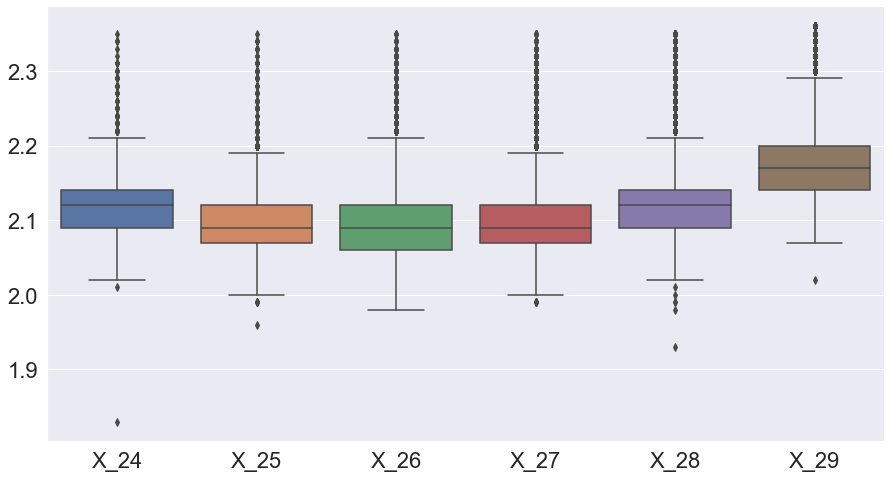

In [ ]:
# 커넥트 핀 치수 
connector = train_x[['X_24','X_25','X_26','X_27','X_28','X_29']]

sns.set(font_scale = 2)
plt.figure(figsize = (15,8))
sns.boxplot(data = connector)
plt.show()

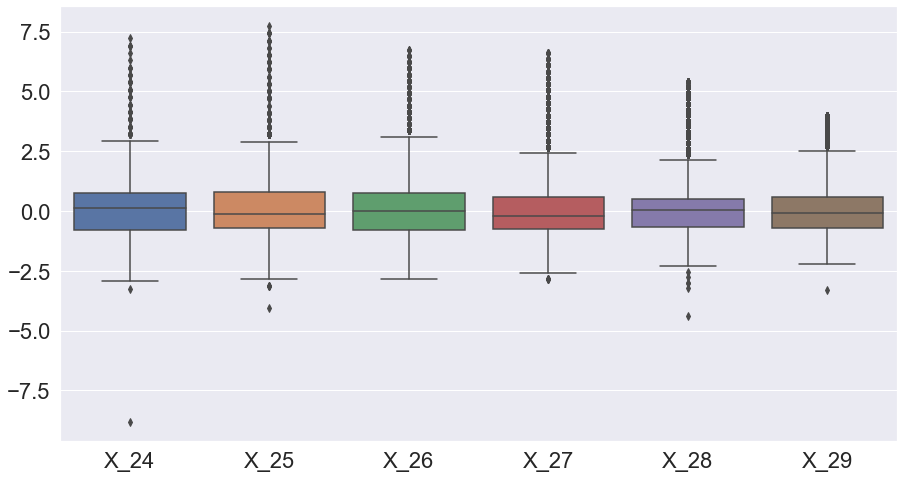

In [ ]:
# 커넥트 핀 치수 
connector = train_x[['X_24','X_25','X_26','X_27','X_28','X_29']]

connector = standardization(connector)

sns.set(font_scale = 2)
plt.figure(figsize = (15,8))
sns.boxplot(data = connector)
plt.show()

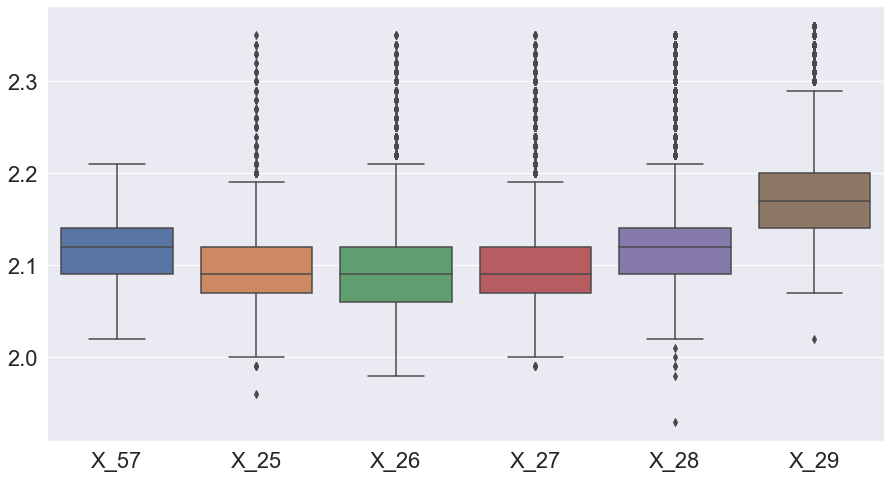

In [ ]:
train_x.loc[:,'X_57'] = IQR_except_outlier(train_x.loc[:,'X_24'].copy())

connector = train_x[['X_57','X_25','X_26','X_27','X_28','X_29']]

sns.set(font_scale = 2)
plt.figure(figsize = (15,8))
sns.boxplot(data = connector)
plt.show()

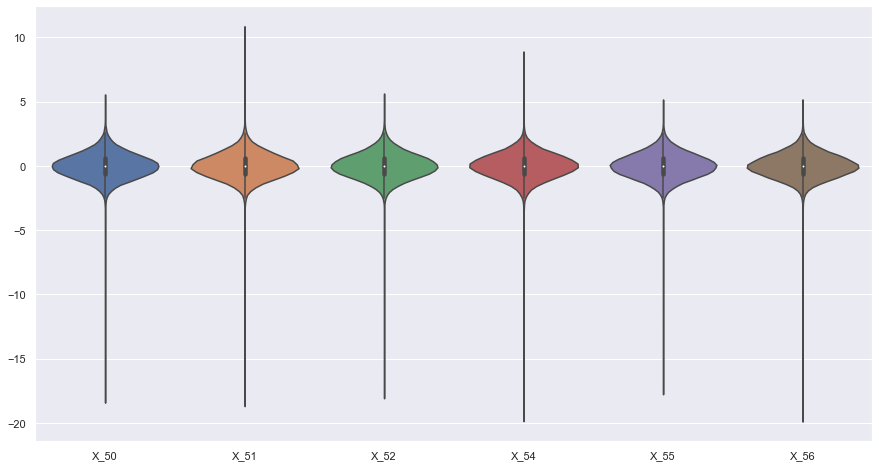

In [ ]:
# RF1 part SMT lead volume

smt = train_x[[ 'X_50', 'X_51', 'X_52', 'X_54', 'X_55', 'X_56']]

smt = standardization(smt)

rf = ['X_50', 'X_51', 'X_52', 'X_54', 'X_55', 'X_56']

sns.set(font_scale = 1)
plt.figure(figsize = (15,8))
sns.violinplot(data = smt)
plt.show()

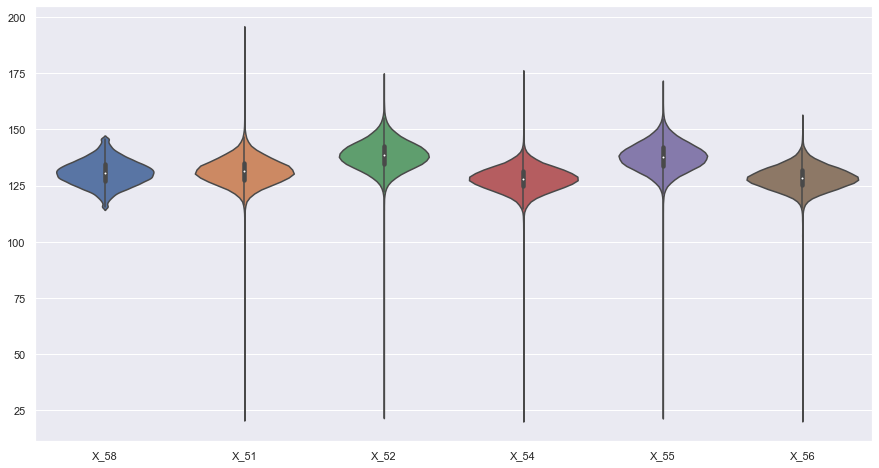

In [ ]:
train_x.loc[:,'X_58'] = IQR_except_outlier(train_x.loc[:,'X_50'].copy())

smt = train_x[[ 'X_58', 'X_51', 'X_52', 'X_54', 'X_55', 'X_56']]

rf = ['X_50', 'X_51', 'X_52', 'X_54', 'X_55', 'X_56']

sns.set(font_scale = 1)
plt.figure(figsize = (15,8))
sns.violinplot(data = smt)
plt.show()
